In [40]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import function_library_assignment_2 as fnc
import logging

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['axes.axisbelow'] = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
random.seed(2) #seed to ensure that we can get the same random values again
wind_scenarios = random.sample(range(100), 50) #How many scenarios? Sampling without replacement - taking 100 samples will just get a list from 0 to 99
wind_scenarios.sort()
#wind_scenarios

In [42]:
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')[['C ($/MWh)', 'C+($/MWh)', 'C-($/MWh)']]
#line_data = fnc.read_data('line_data')
#branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=wind_scenarios) #The ED is only for a single hour - in this case, we choose hour 31

In [ ]:
wind_data_max = wind_data.max(axis=1)
print(wind_data_max)



In [44]:
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs

C ($/MWh)  C+($/MWh)  C-($/MWh)
0      0.618   1.408333        0.9
1      0.618   1.408333        0.9
2      0.618   1.408333        0.9
3      0.618   1.408333        0.9
4      0.618   1.408333        0.9
5      0.618   1.408333        0.9

In [45]:
t = 0 #hour
demand = system_demand[t]

n_gen = len(gen_data.index)
n_wf = len(wind_data.index)
n_scenarios = len(wind_scenarios)
p_max_wf = 300

In [46]:
output = 0 #0/1

In [47]:
# Logging module
logging.basicConfig(level=logging.INFO)  # Setting logging level
logger = logging.getLogger(__name__)  # Create logger

In [113]:
class setting(object):
    '''
        storing class attributes 
    '''
    pass

class benders_subproblem: # suproblem class

    def __init__(self,master,scenario,P_G_master,P_W_master): # initialize class
        self.data = setting() # define data attributes
        self.variables = setting() # define variable attributes
        self.constraints = setting() # define constraints attributes
        self.master = master # define master problem to which subproblem is attached
        self._init_data(scenario,P_G_master,P_W_master) # initialize data
        self._build_model() # build gurobi model


        
    def _init_data(self,scenario,P_G_master,P_W_master): # initialize data

        self.data.scenario = scenario # add scenario
        self.data.P_G_master = P_G_master # add initial value of complicating variables
        self.data.P_W_master = P_W_master # add initial value of complicating variables
        

    def _build_model(self): # build gurobi model
        
        self.model = gb.Model(name='subproblem') # build model
        self.model.setParam('OutputFlag', output)
        self._build_variables() # add variables
        self._build_objective() # add objective
        self._build_constraints() # add constraints
        self.model.update() #update model


    def _build_variables(self): # build variables

        #index shortcut 
        m = self.model
        
        # complicating variables
        self.variables.P_G = m.addVars(n_gen,lb=0,ub=gb.GRB.INFINITY,name='P_G') #generator production
        self.variables.P_W = m.addVars(n_wf, lb=0,ub=gb.GRB.INFINITY ,name='P_W') #wind farm production

        self.variables.P_G_UP = m.addVars(n_gen, lb=0,ub=gb.GRB.INFINITY,name='P_G_UP') # upwards adjustment of generators
        self.variables.P_G_DW = m.addVars(n_gen,lb=0,ub=gb.GRB.INFINITY,name='P_G_DW') # downwards adjustment of generators
        self.variables.P_W_UP = m.addVars(n_wf, lb=0,ub=gb.GRB.INFINITY, name='P_W_UP') # upwards adjustment of wind farms
        self.variables.P_W_DW = m.addVars(n_wf, lb=0,ub=gb.GRB.INFINITY,name='P_W_DW')# downwards adjustment of wind farms
       
       
        m.update()
    

    def _build_objective(self): # build objective function
  
        m = self.model

        # Set Subproblem objective function
        subproblem_obj = gb.quicksum((gen_costs['C+($/MWh)'][g] * self.variables.P_G_UP[g] - gen_costs['C-($/MWh)'][g] * self.variables.P_G_DW[g]) for g in range(n_gen)) + gb.quicksum((wf_costs['C+($/MWh)'][w] * self.variables.P_W_UP[w] - wf_costs['C-($/MWh)'][w] * self.variables.P_W_DW[w]) for w in range(n_wf))   
        m.setObjective(subproblem_obj, gb.GRB.MINIMIZE) #minimize cost

        m.update() 
        

    def _build_constraints(self): #build constraints

        m = self.model

        self.data.P_G_master = [0.00, 0.00, 0.00, 0.00, 0.00, 40.00, 80.00, 300.00, 200.00, 100.00, 110, 60.00]
        self.data.P_W_master = [60.00, 70, 80, 90.0, 49, 30]

        self.constraints.P_G_i = m.addConstrs(self.variables.P_G[g] == self.data.P_G_master[g] for g in range(n_gen))# fix complicating variables to master problem solutions
                        
        self.constraints.P_W_i = m.addConstrs(self.variables.P_W[w] == self.data.P_W_master[w] for w in range(n_wf))# fix complicating variables to master problem solutions
                        
        #Real-time balance constraint
        self.constraints.RT_balance_constraint = m.addConstr(gb.quicksum(self.variables.P_G_UP[g] - self.variables.P_G_DW[g] for g in range(n_gen)) + 
                                                                  gb.quicksum(self.variables.P_W_UP[w] - self.variables.P_W_DW[w] for w in range(n_wf)) == 0)
        
        self.constraints.adjustment_max_generation_constraint = {} #max production of generators after adjustment
        
        #Real-time limits
        self.constraints.RT_G_min = m.addConstrs(self.variables.P_G[g] + self.variables.P_G_UP[g] - self.variables.P_G_DW[g] >= 0 for g in range(n_gen))
        self.constraints.RT_W_min = m.addConstrs(self.variables.P_W[w] + self.variables.P_W_UP[w] - self.variables.P_W_DW[w] >= 0 for w in range(n_wf))

        self.constraints.RT_G_max = m.addConstrs(self.variables.P_G[g] + self.variables.P_G_UP[g] - self.variables.P_G_DW[g] <= gen_data['P max MW'][g] for g in range(n_gen))
        self.constraints.RT_W_max = m.addConstrs(self.variables.P_W[w] + self.variables.P_W_UP[w] - self.variables.P_W_DW[w] <= wind_data[wind_data.columns[self.data.scenario]][w + 1] for w in range(n_wf)) #accounting for wind scenario

        #Real-time regulating power bounds
        self.constraints.P_UP_PB = m.addConstrs(self.variables.P_G_UP[g] <= gen_data['R+ MW'][g] for g in range(n_gen))
        self.constraints.P_DW_PB = m.addConstrs(self.variables.P_G_DW[g] <= gen_data['R- MW'][g] for g in range(n_gen))

        self.constraints.W_UP_PB = m.addConstrs(self.variables.P_W_UP[w] <= p_max_wf for w in range(n_wf))
        self.constraints.W_DW_PB = m.addConstrs(self.variables.P_W_DW[w] <= p_max_wf for w in range(n_wf))
                
        m.update()


    def _update_complicating_variables(self): # updates complicating variables

        m = self.model

        for g in range(n_gen):
            self.constraints.P_G_i[g].rhs = self.master.variables.P_G[g].x
        for w in range(n_wf):
            self.constraints.P_W_i[w].rhs = self.master.variables.P_W[w].x
    
        m.update()

        logger.debug("Updated complicating variables in subproblem.")



class benders_master: # master problem class
    
    def __init__(self,epsilon,max_iters): # initialize class
        self.data = setting()
        self.variables = setting()
        self.constraints = setting()
        self._init_data(epsilon,max_iters)
        self._build_model()
        
    
        
    def _init_data(self,epsilon,max_iters): # initialize data

        self.data.epsilon = epsilon # convergence criteria
        self.data.max_iters = max_iters # max number of iterations
        self.data.iteration = 1 # initialize value of iteration count
        self.data.upper_bounds = {} # initialize list of upper-bound values
        self.data.lower_bounds = {} # initialize list of lower-bound values
        self.data.P_G_duals = {} # initialize list of sensitivities values
        self.data.P_G_values = {} # initialize list of complicating variables values
        self.data.dual_values = {} # initialize list of complicating variables values
        self.data.P_W_duals = {} # initialize list of sensitivities values
        self.data.P_W_values = {} # initialize list of complicating variables values
        self.data.P_G_UP_values = {} # initialize list of subproblem variables values
        self.data.P_G_DW_values = {} # initialize list of subproblem variables values
        self.data.P_G_UP_values = {} # initialize list of subproblem variables values
        self.data.P_W_UP_values = {} # initialize list of subproblem variables values
        self.data.P_W_DW_values = {} # initialize list of subproblem variables values
        self.data.gamma_values = {} # initialize list of gamma values
        self.data.subproblem_objectives = {} # initialize list of subproblems objective values
        self.data.subproblem_variables = {} # initialize list of subproblems optimal variable values
        self.data.master_objectives = {} # initialize list of master problem objective values

    def _build_model(self):
        
        self.model = gb.Model(name='master') # build model
        self.model.setParam('OutputFlag', output)
        self._build_variables() 
        self._build_objective()
        self._build_constraints()
        self.model.update()


    def _build_variables(self): 
 
        m = self.model
        
        # complicating variables
        self.variables.P_G = m.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") 
        self.variables.P_W = m.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed

        # auxiliary variable gamma (for subprblem objectives)
        self.variables.gamma = m.addVar(lb=-1e9,name='gamma')
        m.update()
    

    def _build_objective(self):
  
        m = self.model 

        # Set MAster objective function
        master_obj = gb.quicksum(gen_costs['C ($/MWh)'][g]*self.variables.P_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * self.variables.P_W[w] for w in range(n_wf)) + self.variables.gamma # expected electricity production cost (z)     
        m.setObjective(master_obj, gb.GRB.MINIMIZE) #minimize cost

        m.update() 

    def _build_constraints(self): 
 
        m = self.model
            
       #Day-ahead constraint
        self.constraints.DA = m.addConstr(gb.quicksum(self.variables.P_G[g] for g in range(n_gen)) + gb.quicksum(self.variables.P_W[w] for w in range(n_wf)) - demand == 0)
        
        self.constraints.DA_G = m.addConstrs(self.variables.P_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))
        self.constraints.DA_W = m.addConstrs(self.variables.P_W[w] <= wind_data_max[w+1] for w in range(n_wf))

        self.constraints.master_cuts = {} # initialize master problem cuts (empty)
        
        m.update()


    def _build_subproblems(self): # builds subproblems
        
        self.subproblem = {k:benders_subproblem(master = self, scenario=k , P_G_master={g:self.variables.P_G[g].x for g in range(n_gen)},
                                                                            P_W_master={w:self.variables.P_W[w].x for w in range(n_wf)}) 
                            for k in range(n_scenarios)}
        
        

    def _update_master_cut(self): # adds cuts to master problem

        m = self.model

        gen_sum_term = gb.quicksum(gb.quicksum(gen_costs['C+($/MWh)'][g] * self.data.P_G_UP_values[self.data.iteration - 1][g, xi] -
                                                                    gen_costs['C-($/MWh)'][g] * self.data.P_G_DW_values[self.data.iteration - 1][g, xi]+        
                                                                    self.data.P_G_duals[self.data.iteration - 1][g, xi] * (self.variables.P_G[g] -
                                                                    self.data.P_G_values[self.data.iteration - 1][g]) for g in range(n_gen)) for xi in range(n_scenarios))
        
        wf_sum_term = gb.quicksum(gb.quicksum(wf_costs['C+($/MWh)'][w] * self.data.P_W_UP_values[self.data.iteration - 1][w, xi] -
                                                                    wf_costs['C-($/MWh)'][w] * self.data.P_W_DW_values[self.data.iteration - 1][w, xi] +        
                                                                    self.data.P_W_duals[self.data.iteration - 1][w, xi] * (self.variables.P_W[w] -
                                                                    self.data.P_W_values[self.data.iteration - 1][w]) for w in range(n_wf)) for xi in range(n_scenarios))

        self.constraints.master_cuts[self.data.iteration] = m.addConstr(self.variables.gamma >= (1/n_scenarios) * (gen_sum_term + wf_sum_term), 
                                                            name='new (uni)-cut at iteration {0}'.format(self.data.iteration))

        m.update()
        logger.debug("Updated master cut.")
    
    
    def _save_master_data(self): # saves results of master problem optimization at each iteration
        
        # index shortcut
        m = self.model
        
        # save complicating variables value
        self.data.P_G_values[self.data.iteration] = {g:self.variables.P_G[g].x for g in range(n_gen)}
        self.data.P_W_values[self.data.iteration] = {w:self.variables.P_W[w].x for w in range(n_wf)}
        
        # save gamma value
        self.data.gamma_values[self.data.iteration] = self.variables.gamma.x
        logger.info(f"Iteration {self.data.iteration}: Gamma: {self.data.gamma_values[self.data.iteration]}")

          
        # save lower bound value
        self.data.lower_bounds[self.data.iteration] = m.ObjVal
        logger.info(f"Iteration {self.data.iteration}: Lower Bound: {self.data.lower_bounds[self.data.iteration]}")


        # save master problem objective value
        self.data.master_objectives[self.data.iteration] = m.ObjVal - self.variables.gamma.x

        # Log the values of P_G and P_W
        logger.info(f"Iteration {self.data.iteration}: P_G values: {self.data.P_G_values[self.data.iteration]}")
        logger.info(f"Iteration {self.data.iteration}: P_W values: {self.data.P_W_values[self.data.iteration]}")

           
        m.update()

    def _save_subproblems_data(self): # saves results of subproblems optimization at each iteration
        
        m = self.model

        if self.model.status != gb.GRB.OPTIMAL:
            logger.warning(f"Warning: Model status is not optimal. Status: {self.model.status}")
            return


        # save sensitivities
        self.data.P_G_duals[self.data.iteration] = {(g,k):self.subproblem[k].constraints.P_G_i[g].Pi for g in range(n_gen) for k in range(n_scenarios)}
        self.data.P_W_duals[self.data.iteration] = {(w,k):self.subproblem[k].constraints.P_W_i[w].Pi for w in range(n_wf) for k in range(n_scenarios)}
      
        logger.info(f"Iteration {self.data.iteration}: P_G dual values: {self.data.P_G_duals[self.data.iteration]}")
        logger.info(f"Iteration {self.data.iteration}: P_W dual values: {self.data.P_W_duals[self.data.iteration]}")

        # save subproblems objective values
        self.data.subproblem_objectives[self.data.iteration] = {k:self.subproblem[k].model.ObjVal for k in range(n_scenarios)}             
        
        # save subproblems variable values
        self.data.P_G_UP_values[self.data.iteration] = {(g,k):self.subproblem[k].variables.P_G_UP[g].x for g in range(n_gen) for k in range(n_scenarios)}
        self.data.P_G_DW_values[self.data.iteration] = {(g,k):self.subproblem[k].variables.P_G_DW[g].x for g in range(n_gen) for k in range(n_scenarios)}
        self.data.P_W_UP_values[self.data.iteration] = {(w,k):self.subproblem[k].variables.P_W_UP[w].x for w in range(n_wf) for k in range(n_scenarios)}
        self.data.P_W_DW_values[self.data.iteration] = {(w,k):self.subproblem[k].variables.P_W_DW[w].x for w in range(n_wf) for k in range(n_scenarios)}


        # Log the values of P_G_UP, P_G_DW, P_W_UP, and P_W_DW
        logger.info(f"Iteration {self.data.iteration}: P_G_UP values: {self.data.P_G_UP_values[self.data.iteration]}")
        logger.info(f"Iteration {self.data.iteration}: P_G_DW values: {self.data.P_G_DW_values[self.data.iteration]}")
        logger.info(f"Iteration {self.data.iteration}: P_W_UP values: {self.data.P_W_UP_values[self.data.iteration]}")
        logger.info(f"Iteration {self.data.iteration}: P_W_DW values: {self.data.P_W_DW_values[self.data.iteration]}")

        # save upper bound value
        self.data.upper_bounds[self.data.iteration] = self.data.master_objectives[self.data.iteration] + (1/n_scenarios) * sum(self.subproblem[k].model.ObjVal for k in range(n_scenarios))
        logger.info(f"Iteration {self.data.iteration}: Upper Bound: {self.data.upper_bounds[self.data.iteration]}")


        m.update()

    def _do_benders_step(self): # does one benders step
        logger.info(f"Starting Benders iteration {self.data.iteration}...")
        
        m = self.model

        if self.data.iteration > 1:
            self._update_master_cut() # add cut

        m.optimize() # optimize master problem
        self._save_master_data() # save master problem optimization results

        for k in range(n_scenarios): 

            if self.data.iteration > 1:
                self.subproblem[k]._update_complicating_variables() # update complicating constraints in subproblems

            self.subproblem[k].model.optimize() # solve subproblems

        self._save_subproblems_data() # save subproblems optimization results

               
    def _benders_iterate(self): # solves the benders algorithm iteratively
        
        m = self.model
        
        # initial iteration: 
        m.optimize() #   solve master problem
        self._save_master_data() # save results of master problem and lower bound
        self._build_subproblems() # build subproblems
        for k in range(n_scenarios): 
            self.subproblem[k].model.optimize() # solve subproblems

            if self.subproblem[k].model.status != gb.GRB.OPTIMAL:
                logger.warning(f"Warning: Subproblem {k} status is not optimal. Status: {self.subproblem[k].model.status}")
                return

        self._save_subproblems_data() # save results of subproblems and upper bound
        
        finished = False

        # do benders steps until convergence
        while not finished:
            #print('\nIteration %d...' % self.data.iteration)
            logger.info(f"Iteration {self.data.iteration}...")

            if self.data.iteration > self.data.max_iters:
                finished = True
                logger.error('Error: Maximum iterations reached.')
                break
            
            self._do_benders_step()

            if self.data.iteration >= 2:
                error = abs(self.data.upper_bounds[self.data.iteration] - self.data.lower_bounds[self.data.iteration])
                logger.info('|UB - LB| = %.2f' % error)
                
                if error < self.data.epsilon:
                    finished = True
                    logger.info('Success: Converged at iteration %d.' % self.data.iteration)
                    break

            self.data.iteration += 1 # go to next iteration 
            
#solve and print results

BD_model = benders_master(epsilon=1e-3, max_iters=150)
BD_model._benders_iterate()

# Configure logging level and format
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

p_G = BD_model.data.P_G_values[BD_model.data.iteration]
p_W = BD_model.data.P_W_values[BD_model.data.iteration]
total_sum_g = sum(p_G.values())
total_sum_w = sum(p_W.values())
total_sum = total_sum_w+total_sum_g
print(total_sum)



INFO:__main__:Iteration 1: Gamma: -1000000000.0
INFO:__main__:Iteration 1: Lower Bound: -999996454.8563013
INFO:__main__:Iteration 1: P_G values: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 128.15210452552947, 8: 400.0, 9: 300.0, 10: 0.0, 11: 0.0}
INFO:__main__:Iteration 1: P_W values: {0: 145.6161047475582, 1: 172.4793487371387, 2: 189.0998422521276, 3: 190.6850534700429, 4: 115.2240423361647, 5: 134.5785039314385}
INFO:__main__:Iteration 1: P_G dual values: {(0, 0): 0.0, (0, 1): 0.0, (0, 2): -3.0, (0, 3): -9.591666666666667, (0, 4): -3.0, (0, 5): -9.591666666666667, (0, 6): -3.0, (0, 7): -3.0, (0, 8): -3.0, (0, 9): 0.0, (0, 10): 0.0, (0, 11): -9.591666666666667, (0, 12): -9.591666666666667, (0, 13): 0.0, (0, 14): -4.0, (0, 15): -9.591666666666667, (0, 16): -9.591666666666667, (0, 17): 0.0, (0, 18): -3.0, (0, 19): -9.591666666666667, (0, 20): -4.0, (0, 21): -3.0, (0, 22): 0.0, (0, 23): -3.0, (0, 24): 0.0, (0, 25): -3.0, (0, 26): 0.0, (0, 27): -9.591666666666667, (0, 28

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 89.1527773789922, 6: 29.999999999998128, 7: 400.0, 8: 400.0, 9: 300.0, 10: 60.00000000000126, 11: 40.00000000000167}
1775.835


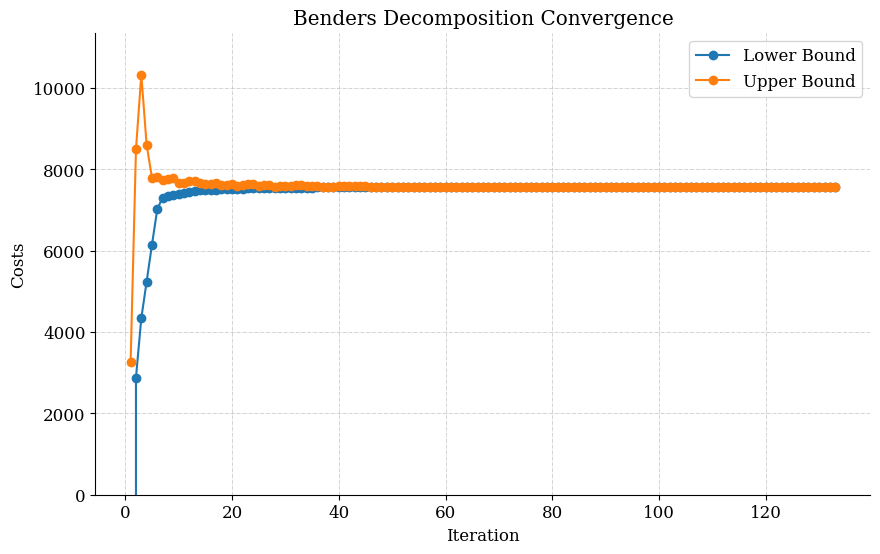

In [114]:
upper_max = max(BD_model.data.upper_bounds.values())

plt.figure(figsize=(10, 6))
plt.plot(BD_model.data.lower_bounds.keys(), BD_model.data.lower_bounds.values(), label='Lower Bound', marker='o')
plt.plot(BD_model.data.upper_bounds.keys(), BD_model.data.upper_bounds.values(), label='Upper Bound', marker='o')
plt.ylim(0, upper_max + 0.1 * abs(upper_max))

plt.xlabel('Iteration')
plt.ylabel('Costs')
plt.title('Benders Decomposition Convergence')

plt.legend()
plt.show()
